In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import chic

from astropy import units as u
from astropy import constants as C
from astropy.cosmology import Planck18
from tqdm.auto import tqdm

## Problem 1

### Part 5

We have found 
$$
\dot T_b + 2 H T_b = \frac{8 \sigma_{\rm T} \rho_\gamma}{3 m_e} \frac{x_e}{1 + x_e + f_{\rm He}} (T_\gamma - T_b)
$$

Below, I've copied my code from homework 5 (with a correction to add the factor of 4 that I removed).

This ultimately gives is a function `electron_fraction` which computes $x_e(z)$, including hydrogen and helium recombinations.

In [15]:
from scipy.integrate import solve_ivp

E_I = 13.6 * u.eV
E_21 = 10.2 * u.eV
E_1 = 24.59 * u.eV
E_2 = 54.42 * u.eV

m_e = (C.m_e * C.c**2).to(u.eV)
m_p = (C.m_p * C.c**2).to(u.eV)
m_H_0 = (m_p + m_e - E_I)
m_He_0 = 4.002602 * (C.u * C.c**2).to(u.eV)
m_He_1 = E_1 + m_He_0 - m_e
m_He_2 = E_2 + m_He_1 - m_e

m_e_tilde = (m_p / m_H_0) * m_e
m_e_tilde1 = m_He_1 / m_He_0 * m_e
m_e_tilde2 = m_He_2 / m_He_1 * m_e

sigma_T = 6.65e-25 * u.cm**2  # Thomson scattering cross section

lambda_21 = (C.h * C.c / E_21).to(u.Angstrom)
Lambda_2g = 8.22 / u.s

def helium_fraction(Y_He):
    ratio = (m_p / m_He_0).to(u.dimensionless_unscaled).value
    return ratio / (1 / Y_He - 1)

def A_B(T: u.Quantity['energy']):
    T4 = T / (1e4 * u.K * C.k_B)
    T4 = T4.to(u.dimensionless_unscaled).value
    return (
        (4.309 * np.pow(T4, -0.6166))
        / (1 + 0.6703 * np.pow(T4, 0.53))
        * (1e-13 * u.cm**3 / u.s)
    )

def saha_equilibrium_RHS(T: u.Quantity['energy'], n_H: u.Quantity['number density']):
    E_over_T = (E_I / T).to(u.dimensionless_unscaled).value
    n_H_eV = (n_H * (C.c * C.hbar)**3).to(u.eV**3)
    eV3_ratio = ((m_e_tilde * T) / (2 * np.pi))**(3/2) / n_H_eV
    eV3_ratio = eV3_ratio.to(u.dimensionless_unscaled).value
    RHS = eV3_ratio * np.exp(-E_over_T)
    return RHS

def peebles_C(T: u.Quantity['energy'], n_H: u.Quantity['number density'], H: u.Quantity['frequency'] = 67.6 * u.km/u.s/u.Mpc):
    E21_over_T = (E_21 / T).to(u.dimensionless_unscaled).value
    _A_B = A_B(T)
    x_eq_RHS = saha_equilibrium_RHS(T, n_H)
    numer = (8 * np.pi * H) / (lambda_21**3 * n_H).to(u.dimensionless_unscaled).value + Lambda_2g

    import warnings
    warnings.filterwarnings("error")
    try:
        four_B_B = n_H * _A_B * np.exp(E21_over_T) * x_eq_RHS
    except RuntimeWarning as w:
        return 1.
    warnings.resetwarnings()
    
    return (numer / (numer + four_B_B)).to(u.dimensionless_unscaled).value

threshold = 1e6

def helium_I(T, f_He, n_H):
    E_over_T = (E_1 / T).to(u.dimensionless_unscaled).value
    n_H_eV = (n_H * (C.c * C.hbar)**3).to(u.eV**3)
    RHS = 4 * (m_e_tilde1 * T / (2 * np.pi))**(3/2) / n_H_eV * np.exp(-E_over_T)
    RHS = RHS.to(u.dimensionless_unscaled).value

    if RHS > threshold:
        return 1 + f_He
    elif RHS < 1 / threshold:
        return 1
    else:
        return 0.5 * (1 - RHS + np.sqrt((1 + RHS)**2 + 4 * f_He * RHS))

def helium_II(T, f_He, n_H):
    E_over_T = (E_2 / T).to(u.dimensionless_unscaled).value
    n_H_eV = (n_H * (C.c * C.hbar)**3).to(u.eV**3)
    RHS = (m_e_tilde2 * T / (2 * np.pi))**(3/2) / n_H_eV * np.exp(-E_over_T)
    RHS = RHS.to(u.dimensionless_unscaled).value
    if RHS > threshold:
        return 1 + 2 * f_He
    elif RHS < 1 / threshold:
        return 1 + f_He
    else:
        return 0.5 * (1 - RHS + f_He + np.sqrt((1 + RHS + f_He)**2 + 4 * f_He * RHS))

class RecombinationSolver:
    def __init__(self):
        self.O_b = Planck18.Ob0
        self.O_m = Planck18.Om0
        self.O_L = Planck18.Ode0
        self.O_r = 1 - self.O_m - self.O_L
        
        self.H_0 = Planck18.H0
        self.h = self.H_0 / (100 * u.km/u.s/u.Mpc)
        self.h = self.h.to(u.dimensionless_unscaled).value

        self.N_eff = Planck18.Neff
        self.Y_He = 0.24
        self.f_He = helium_fraction(self.Y_He)
        self.T_0 = (Planck18.Tcmb0 * C.k_B).to(u.eV)
        
        self.omega_b = self.O_b * self.h**2
        self.n_H_0 = (
            (self.O_b * Planck18.critical_density0)
            / ((m_p + helium_fraction(self.Y_He) * m_He_0) / C.c**2)
        ).to(1 / u.m**3)
    
    def hydrogen_ndensity(self, z):
        return self.n_H_0 * (1 + z)**3

    def hubble(self, z):
        return self.H_0 * np.sqrt(
            self.O_m * (1 + z)**3
            + self.O_r * (1 + z)**4
            + self.O_L
        )

    def temperature(self, z):
        return (1 + z) * self.T_0

    def saha(self, z):
        eq_RHS = saha_equilibrium_RHS(self.temperature(z), self.hydrogen_ndensity(z))
        return 0.5 * (np.sqrt(eq_RHS**2 + 4 * eq_RHS) - eq_RHS)

    def x_e_dot(self, x_e, T, H, n_H):
        _A = A_B(T)
        _C = peebles_C(T, n_H, H)
        saha = saha_equilibrium_RHS(T, n_H)
        return - _C * n_H * _A * (x_e**2 - saha * (1 - x_e))

    def dxe_dz(self, z, x_e):
        _T = self.temperature(z)
        _H = self.hubble(z)
        _n_H = self.hydrogen_ndensity(z)
        _x_e_dot = self.x_e_dot(x_e, _T, _H, _n_H)
        _output = - (_x_e_dot / ((1 + z) * self.hubble(z)))
        _output = _output.to(u.dimensionless_unscaled).value
        return _output

    def solve(self, z_0=1500, z_1=200, z_eval=None):
        x_e_0 = self.saha(z_0)

        result = solve_ivp(
            self.dxe_dz,
            (z_0, z_1),
            np.array([x_e_0]),
            t_eval=z_eval
        )

        if not result.success:
            raise RuntimeError(result.message)

        zs, x_es = result.t, result.y.squeeze()

        return zs, x_es

    def helium_I(self, z):
        return helium_I(
            self.temperature(z),
            self.f_He,
            self.hydrogen_ndensity(z)
        )

    def helium_II(self, z):
        return helium_II(
            self.temperature(z),
            self.f_He,
            self.hydrogen_ndensity(z)
        )

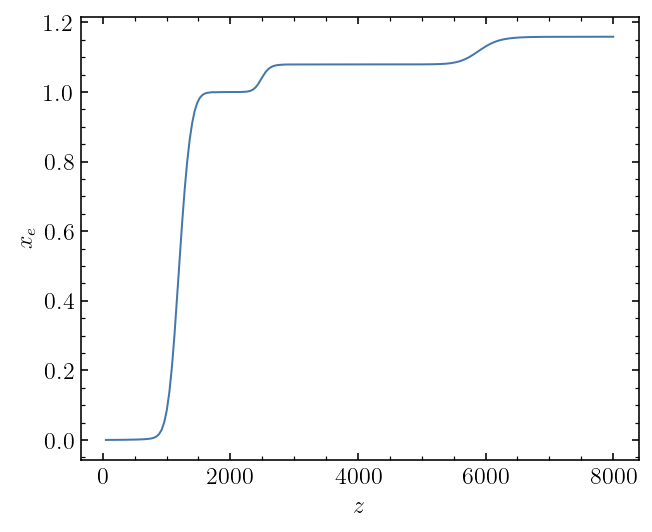

In [16]:
rsolver = RecombinationSolver()

zs = np.linspace(8_000, 50, num=200+1)
done = np.zeros(len(zs), dtype=bool)

# first helium recombination:
x_es = np.array([rsolver.helium_II(z) for z in zs])
# first cutoff:
done |= x_es > (1 + rsolver.f_He)

# second helium recombination
x_e_Is = np.array([rsolver.helium_I(z) for z in zs[~done]])
x_es[~done] = x_e_Is
# second cutoff:
done |= x_es > 1

# hydrogen recombination
H_zs = zs[~done]
z_H, x_e_H = rsolver.solve(z_0 = H_zs[0]+1e-5, z_1 = H_zs[-1]-1e-5, z_eval=H_zs)
x_es[~done] = x_e_H

# plot
plt.plot(zs, x_es, '-', linewidth=1)
plt.xlabel('$z$')
plt.ylabel('$x_e$')

plt.show()

Now, to make a function `electron_fraction` which quickly gets the value of $x_e$ as computed above *without* having to do the full calculation for each individual value of $z$, let's interpolate this function.

In [17]:
from scipy.interpolate import CubicSpline

electron_fraction = CubicSpline(zs[::-1], x_es[::-1])

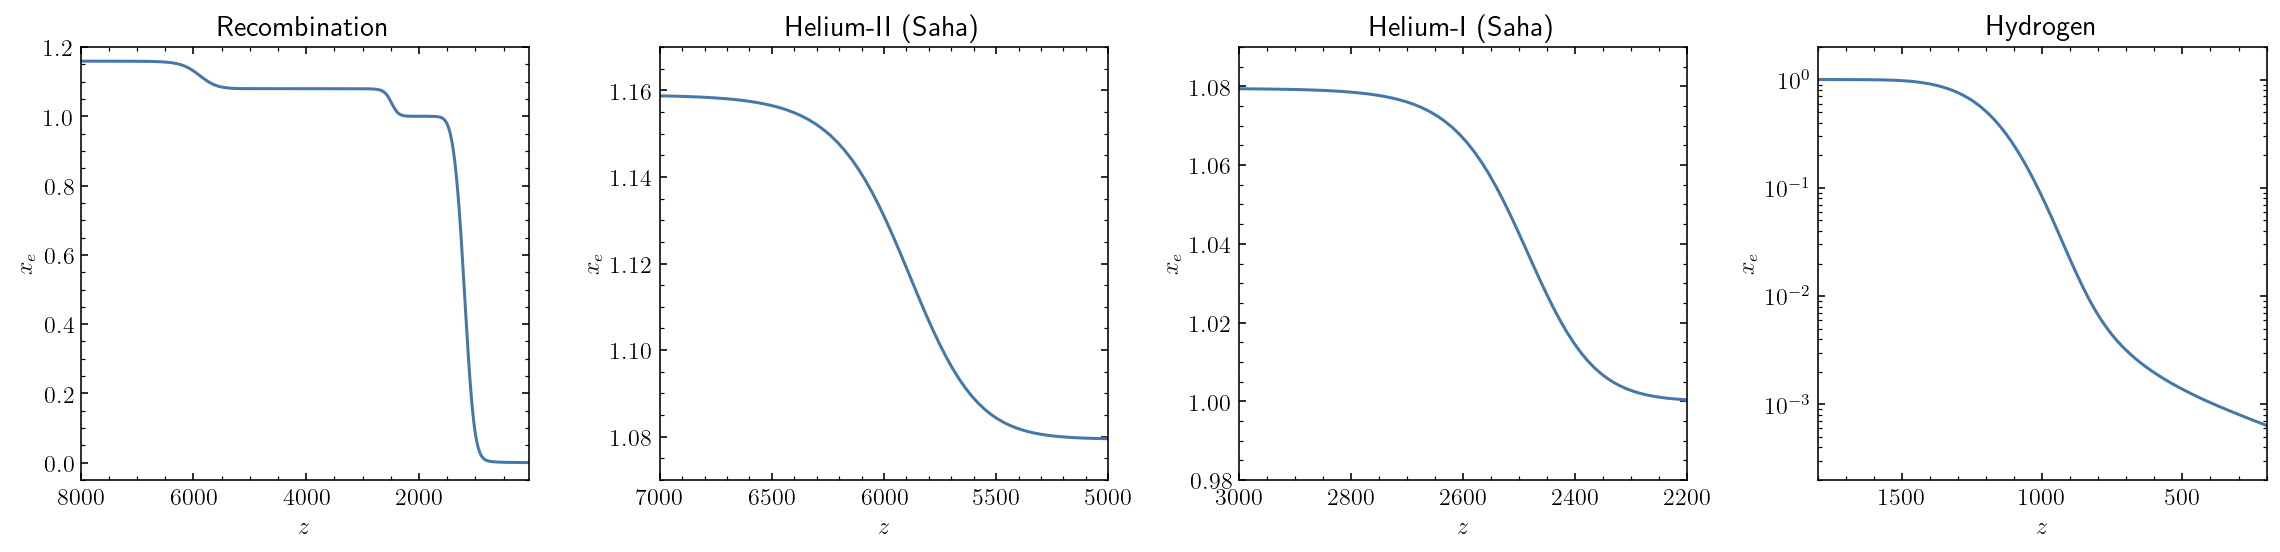

In [18]:
zs = np.geomspace(50, 8000, 1_000+1)
x_es = np.array([electron_fraction(z) for z in zs])

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

axs[0].plot(zs, x_es)
axs[0].set_xlim(8000, 50)
axs[0].set_ylim(-0.05, 1.2)
axs[0].set_title('Recombination')

axs[1].plot(zs, x_es)
axs[1].set_xlim(7000, 5000)
axs[1].set_ylim(1.07, 1.17)
axs[1].set_title('Helium-II (Saha)')

axs[2].plot(zs, x_es)
axs[2].set_xlim(3000, 2200)
axs[2].set_ylim(0.98, 1.09)
axs[2].set_title('Helium-I (Saha)')

axs[3].plot(zs, x_es)
axs[3].set_xlim(1800, 200)
axs[3].set_ylim(2e-4, 2)
axs[3].set_yscale('log')
axs[3].set_title('Hydrogen')

for ax in axs.flat:
    ax.set_xlabel('$z$')
    ax.set_ylabel('$x_e$')

fig.tight_layout()
plt.show()

Now `electron_fraction` computes $x_e(z)$.

We want to compute
$$
\frac{8 \sigma_{\rm T} \rho_\gamma}{3 m_e} \frac{x_e}{1 + x_e + f_{\rm He}} H^{-1} ~.
$$

We have already implemented $H(z)$ and $T_\gamma(z)$ in `rsolver`; the only missing ingredient is the photon density
$$
\rho_\gamma = \frac{8 \pi^5}{15 h^3} T_\gamma^4 = \frac{\pi^2}{15} T_\gamma^4 ~.
$$

In [47]:
def photon_density(z):
    return np.pi**2 / 15 * rsolver.temperature(z)**4

def photon_baryon_coeff_ratio(z):
    H = (rsolver.hubble(z) * C.hbar).to(u.eV)
    x_e = electron_fraction(z)
    rho_g = photon_density(z)
    _sig_T = (sigma_T / (C.hbar * C.c)**2).to(u.eV**-2)
    coeff = 8 * _sig_T * rho_g / (3 * m_e)
    x_e_ratio = x_e / (1 + x_e + rsolver.f_He)
    return (coeff * x_e_ratio / H).to(u.dimensionless_unscaled)

photon_baryon_coeff_ratio(1_000)

<Quantity 20545.25770879>

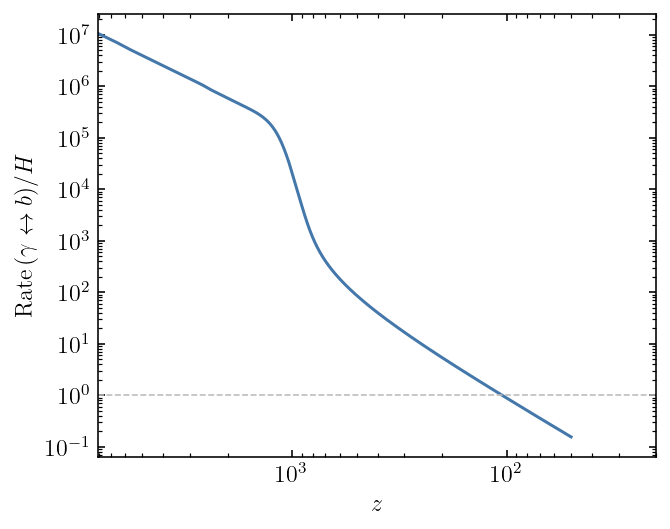

In [61]:
zs = np.geomspace(50, 8000, 1_000+1)
# x_es = np.array([electron_fraction(z) for z in zs])
Rs = np.array([photon_baryon_coeff_ratio(z) for z in zs])

plt.plot(zs, Rs)
plt.xlim(8000 + 30, 50 - 30)
plt.xlabel('$z$')
plt.ylabel('${\\rm Rate} \\, (\\gamma \\leftrightarrow b) / H$')
plt.yscale('log')
plt.xscale('log')
plt.axhline(1, lw=0.8, ls='--', color='C6')
plt.show()

In [65]:
from scipy.optimize import root_scalar

result = root_scalar(lambda z: photon_baryon_coeff_ratio(z) - 1.0, bracket=(200, 60))
if not result.converged:
    raise RuntimeError(f"Failed to converge: {result.flag}")

print(f'z_T = {result.root:.1f}')

z_T = 105.1


## Problem 3

### The equations

Let's precisely write the relativistic scalar cosmological perturbation equations:

Baumann 6.94-95:
$$
\begin{aligned}
\delta' &= \left( 1 + \frac{\bar P}{\bar \rho} \right) (k\, V + 3 \, \phi') - 3 \, \mathcal{H} \left( \frac{\delta P}{\delta \rho} - \frac{\bar P}{\bar \rho} \right)~, \\
V' &= - \left( \mathcal{H} + \frac{\bar P'}{\bar \rho + \bar P} \right) V - \frac{1}{\bar \rho + \bar P} \, k \, \delta P + \frac{2}{3} \, k \, \Pi - k \, \psi~.
\end{aligned}
$$

These equations apply to the total $\delta, V, \delta P, \Pi$, but they also apply separately for any decoupled components.

I'll rewrite these for two choices of $P/\rho$. For radiation, where $P = \rho/3$ (both perturbed and background), we have
$$
\begin{aligned}
\delta' &= \frac{4}{3} \, k \, V + 4 \, \phi'~, \\
V' &= - \frac{1}{4} \, k \, \delta + \frac{2}{3} \, k \, \Pi - k \, \psi~.
\end{aligned}
$$

For matter, where $P \ll \rho$, we have
$$
\begin{aligned}
\delta' &= k\, V + 3 \, \phi'~, \\
V' &= - \mathcal{H} \, V + \frac{2}{3} k \, \Pi - k \, \psi~.
\end{aligned}
$$

If we assume the global anisotropic stress $\Pi = 0$ is zero, then $\psi = \phi$, which we will use below.

### Neutrinos

Neutrinos are decoupled at all relevant times, so they satisfy the above equations alone.

For simplicity, we make the following assumptions about neutrinos:

- Relativistic at all times ($\sim$ massless, so $P_\nu = \rho_\nu/3$)
- Perfect fluid ($\Pi_\nu = 0$) with sound speed $c_\nu^2 = \bar P_\nu' / \bar \rho_\nu' = 1/3$

Then, the equations become
$$
\begin{aligned}
\delta_\nu' &= \frac{4}{3} \, k\, V_\nu + 4 \, \phi'~, \\
V_\nu' &= - \frac{3}{4} \, c_\nu^2 \, k \, \delta_\nu - k \, \phi = - \frac{1}{4} \, k \, \delta_\nu - k \, \phi~.
\end{aligned}
$$

### Cold dark matter

Cold dark matter is decoupled at all times, so it satisfies the above equations alone.

Further, CDM is well-described by a pressureless perfect fluid, so $P_c = 0, \Pi_c = 0$.

So it satisfies:

$$
\begin{aligned}
\delta_c' &= k\, V_c + 3 \, \phi'~, \\
V_c' &= - \mathcal{H} \, V_c - k \, \phi~.
\end{aligned}
$$

### Photons and baryons

Photons and baryons are coupled for part of the time by Thomson scattering, until $z_d = 10^3$.

**Before decoupling**

Before decoupling, we treat the two species in the 'tight coupling' approximation:

- Thomson scattering is much faster than Hubble: $a \, n_e \, \sigma_T \gg \mathcal{H}$
- Photons are an ideal fluid: $\Pi_\gamma \to 0$
- Photons and baryons have approximately the same velocity: $\vec{V}_b - \vec{V}_\gamma \to 0$

In this régime, we can represent the baryons in terms of the photons:
$$
\delta_b = \frac{3}{4} \delta_\gamma~, \quad V_b = V_\gamma~,
$$
where the photon quantities evolve by
$$
\begin{aligned}
\delta_\gamma' &= \frac{4}{3} \, k \, V_\gamma + 4 \, \phi'~, \\
V_\gamma' &= - \frac{R}{1 + R} \, \mathcal{H} \, V_\gamma - k \, \phi - \frac{k}{4 \, (1 + R)} \, \delta_\gamma~,
\end{aligned}
$$
where we have introduced
$$
R \equiv \frac{3}{4} \frac{\bar\rho_b}{\bar\rho_\gamma}~.
$$

**After decoupling**

After decoupling, we treat the baryons and photons as if they are fully decoupled.

We'll make the following assumptions for simplicity:

- Neglect baryon pressure: $P_b = 0$. (This is obviously invalid on very small scales, but those scales are probably going to behave nonlinearly anyway.)
- Neglect photon anisotropic stress: $\Pi_\gamma = 0$, so $c_\gamma^2 = 1/3$.

And recall that baryons have zero anisotropic stress $\Pi_b = 0$.

The equations are then:
$$
\begin{aligned}
\delta_\gamma' &= \frac{4}{3} \, k \, V_\gamma + 4 \, \phi'~, \\
V_\gamma' &= - \frac{1}{4} \, k \, \delta_\gamma - k \, \phi~, \\
\delta_b' &= k\, V_b + 3 \, \phi'~, \\
V_b' &= - \mathcal{H} \, V_b - k \, \phi~.
\end{aligned}
$$

### Potential

Lastly, we need to evolve the potential $\phi$. It obeys
$$
\phi'' + 3 \, (1 + w) \, \mathcal{H} \, \phi' + w \, k^2 \, \phi
= 4 \pi G \, a^2 \, (\delta P - w \, \delta \rho), \quad w \equiv \bar P/ \bar \rho
$$

It would be nice to not have a second-order equation though.

We can accomplish this by splitting $\phi$ into two variables: $\phi_1 \equiv \phi$, $\phi_2 \equiv \phi'$.
However, that would make $\phi_2$ a dimensionful quantity, and it's nicer if all of our integrated variables are dimensionless.
As such, we define $\phi_1 \equiv \phi$, $\phi_2 \equiv d\phi/dz$.

Now we need $\phi'$ and $\phi''$ in terms of these new quantities.

$$
\phi' = \frac{d\phi}{d\eta} = \frac{dz}{d\eta} \frac{d\phi}{dz} = - (1 + z) \, \mathcal{H} \, \phi_2.
$$

$$
\begin{aligned}
\phi''
&= \frac{d}{d\eta} \left[ - (1 + z) \, \mathcal{H} \, \phi_2 \right] \\
&=  - \frac{dz}{d\eta} \, \mathcal{H} \, \phi_2
    - (1+z) \, \frac{d\mathcal{H}}{d\eta} \, \phi_2
    - (1+z) \, \mathcal{H} \, \frac{d\phi_2}{d\eta} \\
&=  (1+z) \, \mathcal{H}^2 \, \phi_2
    + \frac{4\pi G}{3} \, \frac{\bar\rho + \bar P}{1+z} \, \phi_2
    - (1+z) \, \mathcal{H} \, \phi_2'
\end{aligned}
$$

Plugging these in, our second-order ODE is equivalent to the following first-order system:

$$
\begin{aligned}
\phi_1' &= - (1 + z) \, \mathcal{H} \, \phi_2 \\
-(1+z) \, \mathcal{H} \, \phi_2'
&= 
    - (1+z) \, \mathcal{H}^2 \, \phi_2
    - \frac{4\pi G}{3} \, \frac{(1+w) \, \bar\rho}{1+z} \, \phi_2
    + 3 \, (1 + w) \, (1 + z) \, \mathcal{H}^2 \, \phi_2
    - w \, k^2 \, \phi_1
    + 4 \pi G \, a^2 \, (\delta P - w \, \delta \rho), \quad w \equiv \bar P/ \bar \rho
\end{aligned}
$$

I alternatively considered setting $\varphi_1 = \phi, \varphi_2 = d\phi/da$. This gives
$$
\begin{aligned}
\varphi_1' &= a \, \mathcal{H} \, \varphi_2 \\
\varphi_2'
&=  - \frac{7 + 3 w}{2} \, \mathcal{H} \, \varphi_2
    - \frac{w \, k}{\mathcal{H} \, a} \, \varphi_1
    + 4 \pi G \, \frac{a}{\mathcal{H}} (\delta P - w \, \delta \rho)
\end{aligned}
$$

We will also need to be able to compute $\bar\rho, \bar P, \delta\rho, \delta P$. Let's determine how to do that.

$$
\begin{gathered}
\bar\rho(z) = \sum_a \bar\rho_a(z) = \frac{3 \, H_0^2}{8\pi G} \sum_a \Omega_a \, (1+z)^{3(1+w_a)} = \frac{3 \, H(z)^2}{8 \pi G} ~, \\
\bar P(z) = \sum_a \bar P_a(z) = \sum_a w_a \, \bar\rho_a(z)~, \\
\delta\rho(z) = \sum_a \delta\rho_a(z) = \sum_a \bar\rho_a(z) \, \delta_a(z)~, \\
\delta P(z) = \sum_a \delta P_a(z) = \sum_a w_a \, \delta\rho_a(z) = \sum_a w_a \, \bar\rho_a(z) \, \delta_a(z)~.
\end{gathered}
$$

### Integration

Right now our system is sort of mixed; we have derivatives w.r.t. $\eta$, but background quantities (Hubble, bkg density, etc.) in terms of $z$ or $a$.

It is simple to change the integration variable to $z$; it is harder to compute the background quantities in terms of $\eta$ directly. 

(Since finding $a(\eta)$ requires an integral, but $da/d\eta$ is known if you know Hubble.)

As such, we switch our integration variable to $z$. Note that
$$
' \equiv \frac{d}{d\eta}
= \frac{da}{d\eta} \frac{dz}{da} \frac{d}{dz}
= (\mathcal{H} a) \big(-\frac{1}{a^2}\big) \frac{d}{dz}
= - (1+z) \, \mathcal{H} \, \frac{d}{dz}
$$

We also try switching it to $\log a$. Then,
$$
' \equiv \frac{d}{d\eta}
= \frac{da}{d\eta} \frac{d\log a}{da} \frac{d}{d\log a}
= (\mathcal{H} a) \frac{1}{a} \frac{d}{d\log a}
= \mathcal{H} \, \frac{d}{d\log a}
$$

### Initialization

The only thing we haven't handled yet is the initialization.
We're assuming adiabatic ICs, so everything is specified in terms of $\phi_i$.

We've split $\phi$ into two integration variables: $\phi_1 = \phi_i$, $\phi_2 = 0$.
(This is valid because we will start integration deep in the superhorizon régime where $\phi$ is constant.)

The photon overdensity is given by $\delta_\gamma = -2 \phi_i$. The other species' overdensities are given in terms of $\delta_\gamma$:
$$
\delta_\nu = \delta_\gamma~, \quad \delta_b = \delta_c = \frac{3}{4} \, \delta_\gamma~.
$$

Lastly, all velocities are initialized to zero.

Because all the perturbative quantities appear only linearly, they will all be directly proportional to $\phi_i$. Hence, we pick $\phi_i = 1$ and present all our results as $x/\phi_i$.

Finally, we need to specify what it means to "start integration deep in the superhorizon régime." The superhorizon régime is where $k \ll \mathcal{H}$, so if we are given a $k$, we need to pick an initial $z_i$ early enough that $\mathcal{H}(z) \gg k$.

One way to do this might be to pick $\mathcal{H}(a_i) = 100 \, k$ and solve for $z_i$, which would be simple to do numerically.

### Code

In [458]:
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

def dedim(x):
    return x.to(u.dimensionless_unscaled).value

class CCPP():
    """Connor's Cosmological Perturbation Program"""

    def __init__(self):
        self.O_b = Planck18.Ob0
        self.O_m = Planck18.Om0
        self.O_c = self.O_m - self.O_b
        self.O_L = Planck18.Ode0
        self.O_r = 1 - self.O_m - self.O_L
        self.O_g = Planck18.Ogamma0
        self.O_nu = self.O_r - self.O_g
        
        self.H_0 = Planck18.H0
        self.h = dedim(self.H_0 / (100 * u.km/u.s/u.Mpc))

        self.Os = [self.O_g, self.O_b, self.O_c, self.O_nu, self.O_L]
        self.ws = [ 1/3, 0, 0, 1/3, ]# -1 ]

        self.z_d = 1e3

    def hubble(self, z):
        return self.H_0 * np.sqrt(
            self.O_m * (1+z)**3
            + self.O_r * (1+z)**4
            + self.O_L
        )

    def scale_factor(self, z):
        return 1 / (1 + z)

    def curly_hubble(self, z):
        return self.hubble(z) * self.scale_factor(z)

    def bkg_density(self, z):
        rho = 3 * self.hubble(z)**2 / (8 * np.pi * C.G)
        return (rho * C.c / C.hbar).to(u.Mpc**-4)

    def bkg_densities(self, z):
        coef = (3 * self.H_0**2 / (8 * np.pi * C.G) * C.c / C.hbar).to(u.Mpc**-4)
        return [coef * O * (1 + z)**(3 * (1 + w)) for O, w in zip(self.Os, self.ws)]

    def bkg_pressure(self, z):
        rho_bars = self.bkg_densities(z)
        return sum(w * rho_bar for rho_bar, w in zip(rho_bars, self.ws))

    def ptb_density(self, z, deltas):
        rho_bars = self.bkg_densities(z)
        return sum(rho_bar * delta for rho_bar, delta in zip(rho_bars, deltas))

    def ptb_pressure(self, z, deltas):
        rho_bars = self.bkg_densities(z)
        return sum(w * rho_bar * delta for rho_bar, w, delta in zip(rho_bars, self.ws, deltas))

    def dx_dz(self, z, ptbs, k):
        [d_g, d_b, d_c, d_nu, V_g, V_b, V_c, V_nu, phi_1, phi_2] = ptbs

        curly_H = (self.curly_hubble(z) / C.c).to(u.Mpc**-1)

        phi_1_prime = -(1+z) * curly_H * phi_2

        # neutrinos
        d_nu_prime = (4. / 3.) * k * V_nu + 4 * phi_1_prime
        V_nu_prime = - 0.25 * k * d_nu - k * phi_1

        # CDM
        d_c_prime = k * V_c + 3 * phi_1_prime
        V_c_prime = - curly_H * V_c - k * phi_1

        # photons and baryons
        if z > self.z_d:
            # tight-coupling regime
            [rho_bar_g, rho_bar_b, _, _] = self.bkg_densities(z)
            R = 0.75 * rho_bar_b / rho_bar_g

            d_g_prime = (4. / 3.) * k * V_g + 4 * phi_1_prime
            V_g_prime = - R / (1 + R) * curly_H * V_g - k * phi_1 - 0.25 * k * d_g / (1 + R)
            
            d_b_prime = 0.75 * d_g_prime
            V_b_prime = V_g_prime

        else:
            # decoupled regime
            d_g_prime = (4. / 3.) * k * V_g + 4 * phi_1_prime
            V_g_prime = - 0.25 * k * d_g - k * phi_1
            
            d_b_prime = k * V_b + 3 * phi_1_prime
            V_b_prime = - curly_H * V_b - k * phi_1

        # potential
        rho_bar = self.bkg_density(z)
        P_bar = self.bkg_pressure(z)
        w = dedim(P_bar / rho_bar)
        drho = self.ptb_density(z, [d_g, d_b, d_c, d_nu])
        dP = self.ptb_pressure(z, [d_g, d_b, d_c, d_nu])
        
        phi_2_prime = (
            - curly_H * phi_1_prime
            - (4 * np.pi * C.G * C.hbar / C.c**3 / 3) * (1+w) * rho_bar / (1+z) * phi_2
            + 3 * (1 + w) * curly_H * (1+z) * curly_H * phi_2
            - w * k**2 * phi_1 
            + 4 * np.pi * C.G * C.hbar / C.c**3 * (1 + z)**-2 * (dP - w * drho)
        ) / ( -(1+z) * curly_H )

        # these are all d/d(eta)
        # make sure their units are all right
        ptbs_prime = [
            d_g_prime.to(1 / u.Mpc),
            d_b_prime.to(1 / u.Mpc),
            d_c_prime.to(1 / u.Mpc),
            d_nu_prime.to(1 / u.Mpc),
            V_g_prime.to(1 / u.Mpc),
            V_b_prime.to(1 / u.Mpc),
            V_c_prime.to(1 / u.Mpc),
            V_nu_prime.to(1 / u.Mpc),
            phi_1_prime.to(1 / u.Mpc),
            phi_2_prime.to(1 / u.Mpc),
        ]

        # make them all d/dz and dimensionless
        return [
            dedim(ptb_prime / (-(1 + z) * curly_H))
            for ptb_prime in ptbs_prime
        ]

    def get_z_given_H(self, curly_H_des):
        result = root_scalar(lambda z: dedim((self.curly_hubble(z) - curly_H_des) / curly_H_des), bracket=[1, 1e12])
        if not result.converged:
            raise RuntimeError('could not find proper initial z: ' + result.flag)
        return result.root

    def solve(self, k, z_final=10):
        # find a time in the superhorizon era
        z_init = self.get_z_given_H(100 * k * C.c)
        print(f"z_init = {z_init:.1e}")

        ptbs_init = [ -2, -1.5, -1.5, -2, 0, 0, 0, 0, 1, 0 ]
        
        return solve_ivp(
            self.dx_dz,
            (z_init, z_final),
            ptbs_init,
            args=(k,),
            method='Radau'
        )

cpt = CCPP()

In [459]:
result3 = cpt.solve(0.001 * (u.Mpc**-1))
result2 = cpt.solve(0.01 * (u.Mpc**-1))
result1 = cpt.solve(0.1 * (u.Mpc**-1))

results = [
    result1,
    result2,
    result3,
]

z_init = 1.1e+04
z_init = 1.1e+05
z_init = 1.1e+06


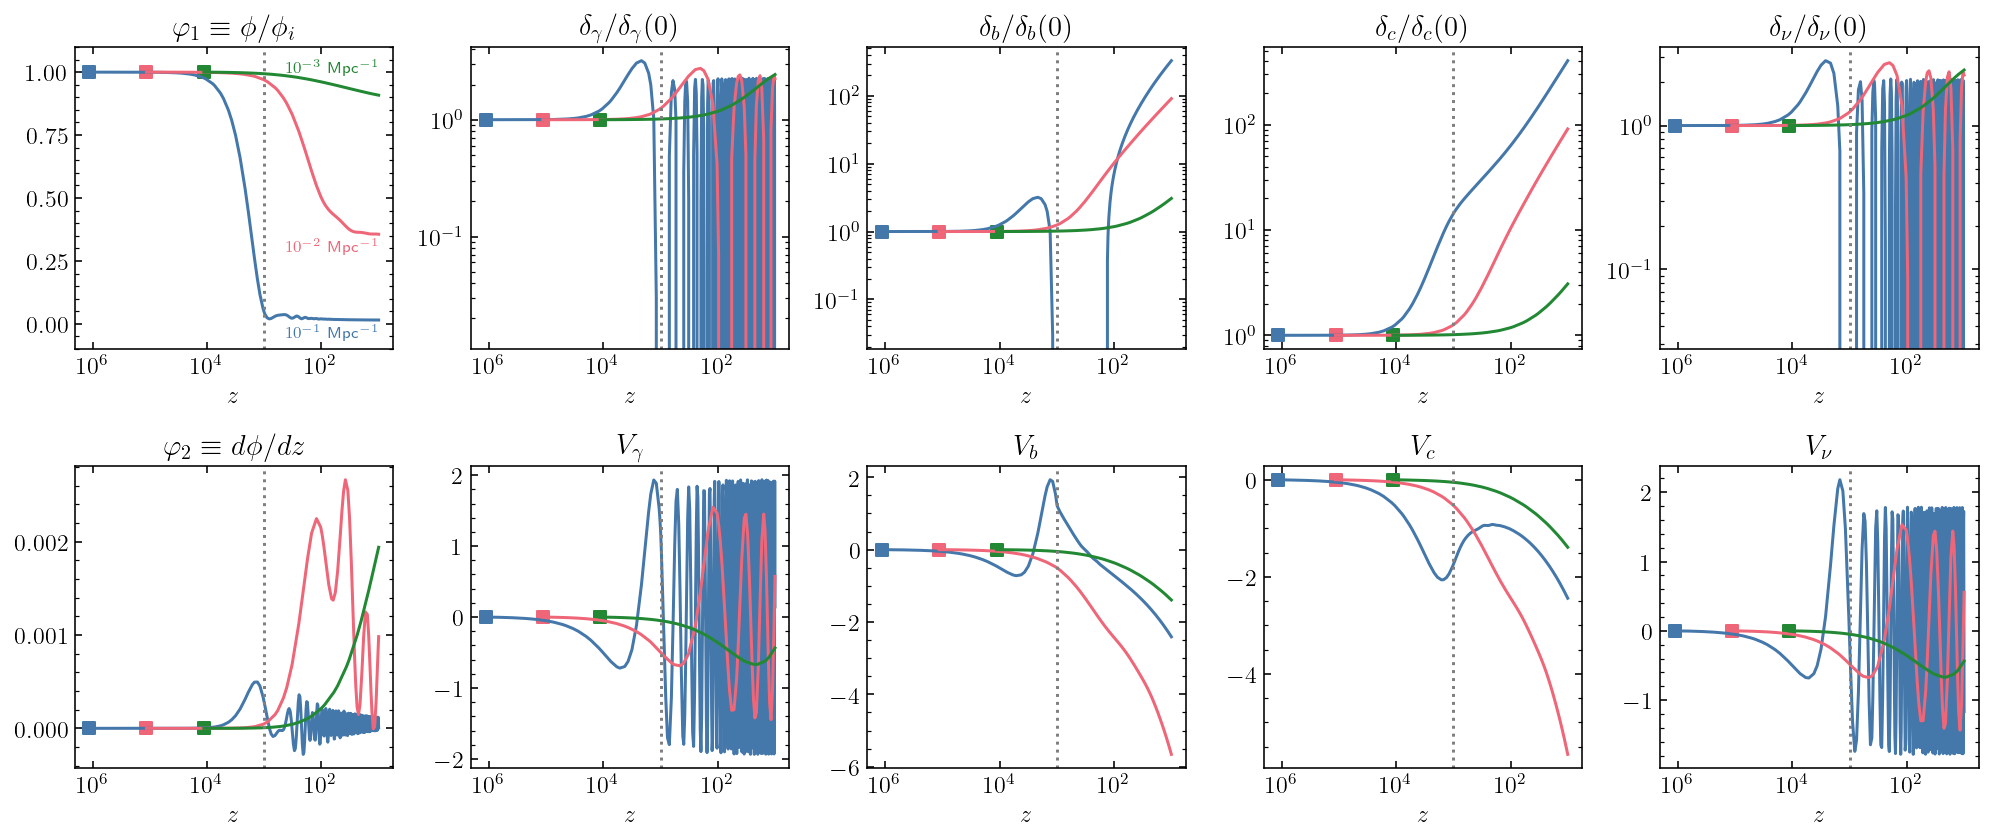

In [460]:
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(4, 5)

d_axes = [ fig.add_subplot(gs[0:2, i+1]) for i in range(4) ]
V_axes = [ fig.add_subplot(gs[2:4, i+1]) for i in range(4) ]
# phi_ax = fig.add_subplot(gs[1:3, 0])
phi_ax = fig.add_subplot(gs[0:2, 0])
phi_prime_ax = fig.add_subplot(gs[2:4, 0])

axs = np.concatenate( [d_axes + V_axes + [phi_ax, phi_prime_ax]] )

labels = [
    '$\\delta_\\gamma / \\delta_\\gamma(0)$',
    '$\\delta_b / \\delta_b(0)$',
    '$\\delta_c / \\delta_c(0)$',
    '$\\delta_\\nu / \\delta_\\nu(0)$',
    '$V_\\gamma$',
    '$V_b$',
    '$V_c$',
    '$V_\\nu$',
    '$\\varphi_1 \\equiv \\phi / \\phi_i$',
    '$\\varphi_2 \\equiv d\\phi/dz$',
]


for i, (ax, label) in enumerate(zip(axs.flat, labels)):
    for j, result in enumerate(results):
        if i < 4:
            ax.plot(result.t, result.y[i] / result.y[i][0], color=f'C{j}')
            ax.scatter(result.t[0], 1, c=f'C{j}', marker='s', s=32)
            ax.set_yscale('log')
        else:
            ax.plot(result.t, result.y[i], color=f'C{j}')
            ax.scatter(result.t[0], result.y[i][0], c=f'C{j}', marker='s', s=32)
        # ax.plot([cpt.scale_factor(z) for z in result.t], result.y[i], color=f'C{j}')
        # ax.scatter(cpt.scale_factor(result.t[0]), result.y[i][0], c=f'C{j}', marker='s', s=32)
    # ax.set_xlim(z_0 * 2, z_1 / 2)
    ax.set_xscale('log')
    ax.set_title(label)
    ax.set_xlabel('$z$')
    ax.axvline(cpt.z_d, ls=':', color='grey')
    ax.set_xlim(*ax.get_xlim()[::-1])

phi_ax.text(results[0].t[-1], results[0].y[8][-1] - 0.08, r'$10^{-1} \ \text{Mpc}^{-1}$', ha='right', va='bottom', fontsize=8, color='C0')
phi_ax.text(results[1].t[-1], results[1].y[8][-1] - 0.08, r'$10^{-2} \ \text{Mpc}^{-1}$', ha='right', va='bottom', fontsize=8, color='C1')
phi_ax.text(results[2].t[-1], results[2].y[8][-1] + 0.08, r'$10^{-3} \ \text{Mpc}^{-1}$', ha='right', va='bottom', fontsize=8, color='C2')
phi_ax.set_ylim(-0.1, 1.1)

fig.tight_layout()
plt.show()

Hmm...

- $\delta_c$ looks good!
- $\phi$ almost looks good, though I think the decay should be stronger before $z_d$ and the oscillations more damped after.
- $b$ is odd but I think I can forgive it, since...
- $\gamma$ (and $\nu$) looks crazy! What on earth is happening? All oscillations after $z_d$? Doesn't make sense.


I'm going to try to change the integration variable to $\log a$ and see if it looks any different.

In [470]:
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

def dedim(x):
    return x.to(u.dimensionless_unscaled).value

class CCPP():
    """Connor's Cosmological Perturbation Program"""

    def __init__(self):
        self.O_b = Planck18.Ob0
        self.O_m = Planck18.Om0
        self.O_c = self.O_m - self.O_b
        self.O_L = Planck18.Ode0
        self.O_r = 1 - self.O_m - self.O_L
        self.O_g = Planck18.Ogamma0
        self.O_nu = self.O_r - self.O_g
        
        self.H_0 = Planck18.H0
        self.h = dedim(self.H_0 / (100 * u.km/u.s/u.Mpc))

        self.Os = [self.O_g, self.O_b, self.O_c, self.O_nu, self.O_L]
        self.ws = [ 1/3, 0, 0, 1/3, ]# -1 ]

        self.z_d = 1e3

    def hubble(self, log_a):
        return self.H_0 * np.sqrt(
            self.O_m * np.exp(-3 * log_a)
            + self.O_r * np.exp(-4 * log_a)
            + self.O_L
        )

    def redshift(self, log_a):
        return np.exp(-log_a) - 1

    def curly_hubble(self, log_a):
        return self.H_0 * np.sqrt(
            self.O_m * np.exp(-1 * log_a)
            + self.O_r * np.exp(-2 * log_a)
            + self.O_L * np.exp(+2 * log_a)
        )

    def bkg_density(self, log_a):
        rho = 3 * self.hubble(log_a)**2 / (8 * np.pi * C.G)
        return (rho * C.c / C.hbar).to(u.Mpc**-4)

    def bkg_densities(self, log_a):
        coef = (3 * self.H_0**2 / (8 * np.pi * C.G) * C.c / C.hbar).to(u.Mpc**-4)
        return [coef * O * np.exp(-3 * (1 + w) * log_a) for O, w in zip(self.Os, self.ws)]

    def bkg_pressure(self, log_a):
        rho_bars = self.bkg_densities(log_a)
        return sum(w * rho_bar for rho_bar, w in zip(rho_bars, self.ws))

    def ptb_density(self, log_a, deltas):
        rho_bars = self.bkg_densities(log_a)
        return sum(rho_bar * delta for rho_bar, delta in zip(rho_bars, deltas))

    def ptb_pressure(self, log_a, deltas):
        rho_bars = self.bkg_densities(log_a)
        return sum(w * rho_bar * delta for rho_bar, w, delta in zip(rho_bars, self.ws, deltas))

    def dx_dz(self, log_a, ptbs, k):
        [d_g, d_b, d_c, d_nu, V_g, V_b, V_c, V_nu, phi_1, phi_2] = ptbs

        a = np.exp(log_a)
        z = self.redshift(log_a)
        curly_H = (self.curly_hubble(log_a) / C.c).to(u.Mpc**-1)

        phi_1_prime = a * curly_H * phi_2

        # neutrinos
        d_nu_prime = (4. / 3.) * k * V_nu + 4 * phi_1_prime
        V_nu_prime = - 0.25 * k * d_nu - k * phi_1

        # CDM
        d_c_prime = k * V_c + 3 * phi_1_prime
        V_c_prime = - curly_H * V_c - k * phi_1

        # photons and baryons
        if z > self.z_d:
            # tight-coupling regime
            [rho_bar_g, rho_bar_b, _, _] = self.bkg_densities(log_a)
            R = 0.75 * rho_bar_b / rho_bar_g

            d_g_prime = (4. / 3.) * k * V_g + 4 * phi_1_prime
            V_g_prime = - R / (1 + R) * curly_H * V_g - k * phi_1 - 0.25 * k * d_g / (1 + R)
            
            d_b_prime = 0.75 * d_g_prime
            V_b_prime = V_g_prime

        else:
            # decoupled regime
            d_g_prime = (4. / 3.) * k * V_g + 4 * phi_1_prime
            V_g_prime = - 0.25 * k * d_g - k * phi_1
            
            d_b_prime = k * V_b + 3 * phi_1_prime
            V_b_prime = - curly_H * V_b - k * phi_1

        # potential
        rho_bar = self.bkg_density(log_a)
        P_bar = self.bkg_pressure(log_a)
        w = dedim(P_bar / rho_bar)
        drho = self.ptb_density(log_a, [d_g, d_b, d_c, d_nu])
        dP = self.ptb_pressure(log_a, [d_g, d_b, d_c, d_nu])
        
        phi_2_prime = (
            -0.5 * (7 + 3 * w) * curly_H * phi_2
            - w * k**2 / (curly_H * a) * phi_1
            + (4 * np.pi * C.G * C.hbar / C.c**3) * a / curly_H * (dP - w * drho)
        )
        
        # these are all d/d(eta)
        # make sure their units are all right
        ptbs_prime = [
            d_g_prime.to(1 / u.Mpc),
            d_b_prime.to(1 / u.Mpc),
            d_c_prime.to(1 / u.Mpc),
            d_nu_prime.to(1 / u.Mpc),
            V_g_prime.to(1 / u.Mpc),
            V_b_prime.to(1 / u.Mpc),
            V_c_prime.to(1 / u.Mpc),
            V_nu_prime.to(1 / u.Mpc),
            phi_1_prime.to(1 / u.Mpc),
            phi_2_prime.to(1 / u.Mpc),
        ]

        # divide by curly H to make them d/d(log a)
        # and properly de-dimensionalize
        return [
            dedim(ptb_prime / curly_H)
            for ptb_prime in ptbs_prime
        ]

    def get_log_a_given_H(self, curly_H_des):
        result = root_scalar(lambda log_a: dedim((self.curly_hubble(log_a) - curly_H_des) / curly_H_des), bracket=[-300, 0])
        if not result.converged:
            raise RuntimeError('could not find proper initial z: ' + result.flag)
        return result.root

    def solve(self, k, a_init=None, a_final=1):
        # find a time in the superhorizon era
        if a_init is None:
            log_a_init = self.get_log_a_given_H(100 * k * C.c)
            print(f"a_init = {np.exp(log_a_init):.1e}")
        
        else:
            log_a_init = np.log(a_init)
        log_a_final = np.log(a_final)

        ptbs_init = [ -2, -1.5, -1.5, -2, 0, 0, 0, 0, 1, 0 ]
        
        return solve_ivp(
            self.dx_dz,
            (log_a_init, log_a_final),
            ptbs_init,
            args=(k,),
            method='Radau'
        )

cpt = CCPP()

In [471]:
result3 = cpt.solve(0.001 * (u.Mpc**-1))
result2 = cpt.solve(0.01 * (u.Mpc**-1))
result1 = cpt.solve(0.1 * (u.Mpc**-1))

results = [
    result1,
    result2,
    result3,
]

a_init = 8.8e-05
a_init = 8.7e-06
a_init = 8.7e-07


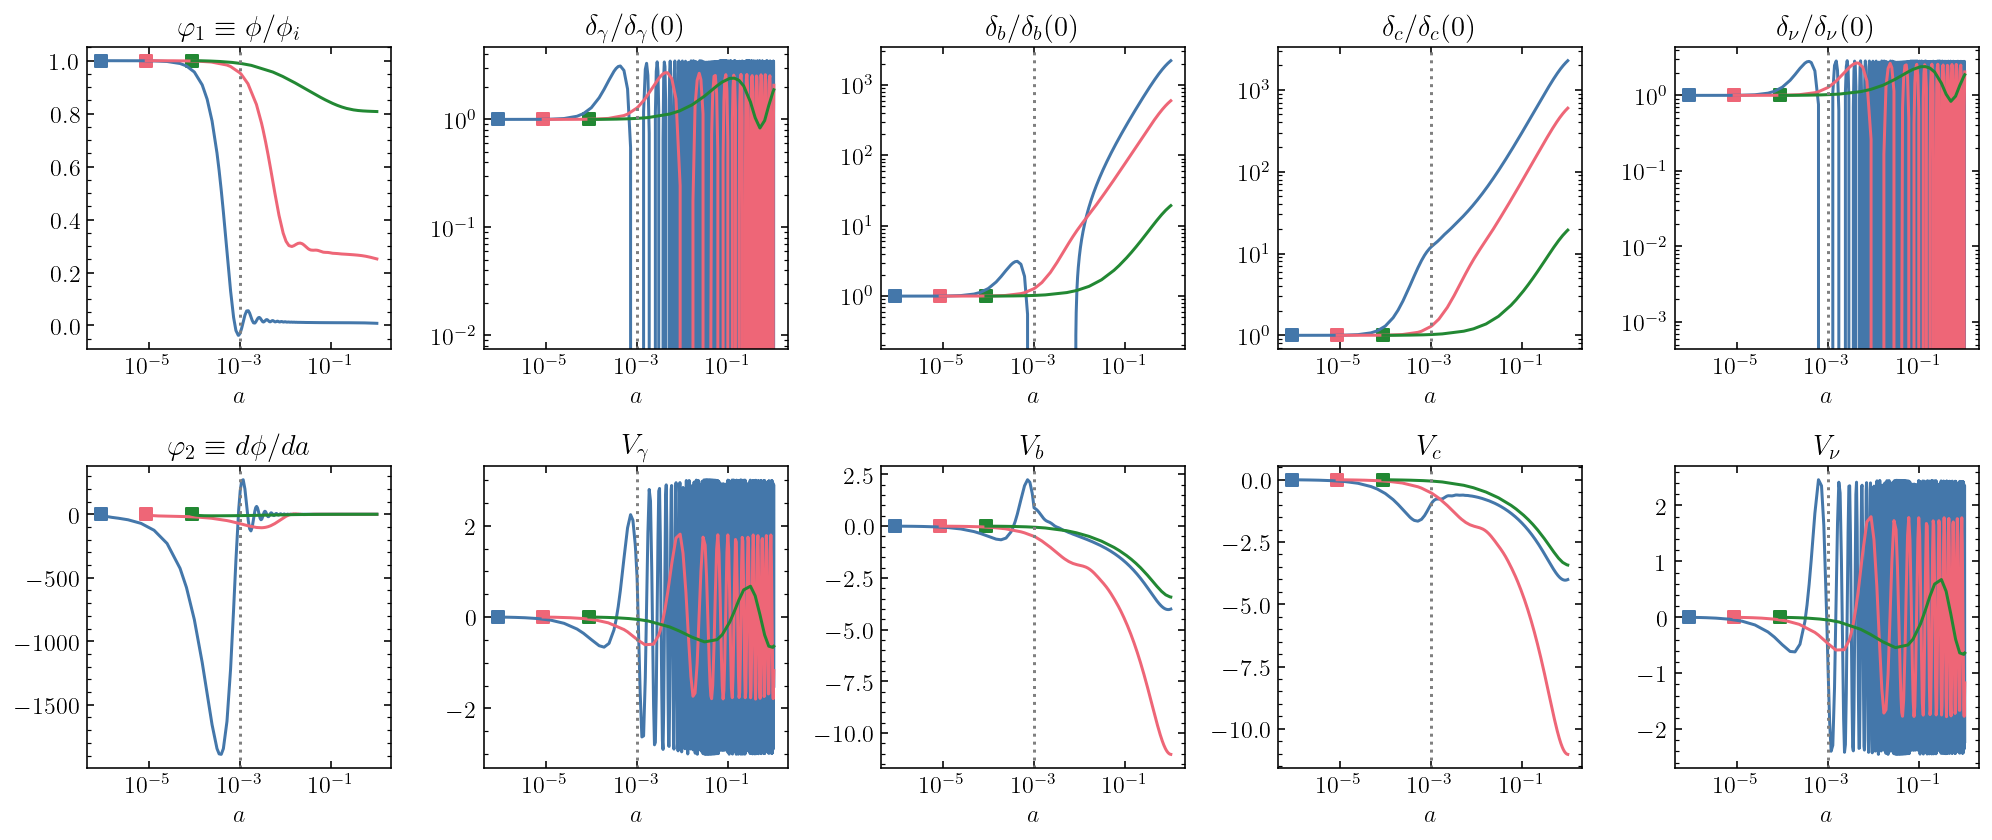

In [472]:
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(4, 5)

d_axes = [ fig.add_subplot(gs[0:2, i+1]) for i in range(4) ]
V_axes = [ fig.add_subplot(gs[2:4, i+1]) for i in range(4) ]
# phi_ax = fig.add_subplot(gs[1:3, 0])
phi_ax = fig.add_subplot(gs[0:2, 0])
phi_prime_ax = fig.add_subplot(gs[2:4, 0])

axs = np.concatenate( [d_axes + V_axes + [phi_ax, phi_prime_ax]] )

labels = [
    '$\\delta_\\gamma / \\delta_\\gamma(0)$',
    '$\\delta_b / \\delta_b(0)$',
    '$\\delta_c / \\delta_c(0)$',
    '$\\delta_\\nu / \\delta_\\nu(0)$',
    '$V_\\gamma$',
    '$V_b$',
    '$V_c$',
    '$V_\\nu$',
    '$\\varphi_1 \\equiv \\phi / \\phi_i$',
    '$\\varphi_2 \\equiv d\\phi/da$',
]

log_a_d = root_scalar(lambda log_a: cpt.redshift(log_a) - cpt.z_d, bracket=[-100, 0]).root

for i, (ax, label) in enumerate(zip(axs.flat, labels)):
    for j, result in enumerate(results):
        if i < 4:
            ax.plot(np.exp(result.t), result.y[i] / result.y[i][0], color=f'C{j}')
            ax.scatter(np.exp(result.t)[0], 1, c=f'C{j}', marker='s', s=32)
            ax.set_yscale('log')
        else:
            ax.plot(np.exp(result.t), result.y[i], color=f'C{j}')
            ax.scatter(np.exp(result.t)[0], result.y[i][0], c=f'C{j}', marker='s', s=32)
        # ax.plot([cpt.scale_factor(z) for z in result.t], result.y[i], color=f'C{j}')
        # ax.scatter(cpt.scale_factor(result.t[0]), result.y[i][0], c=f'C{j}', marker='s', s=32)
    # ax.set_xlim(z_0 * 2, z_1 / 2)
    ax.set_xscale('log')
    ax.set_title(label)
    ax.set_xlabel('$a$')
    ax.axvline(np.exp(log_a_d), ls=':', color='grey')
    # ax.set_xlim(*ax.get_xlim()[::-1])

# phi_ax.text(results[0].t[-1], results[0].y[8][-1] - 0.08, r'$10^{-1} \ \text{Mpc}^{-1}$', ha='right', va='bottom', fontsize=8, color='C0')
# phi_ax.text(results[1].t[-1], results[1].y[8][-1] - 0.08, r'$10^{-2} \ \text{Mpc}^{-1}$', ha='right', va='bottom', fontsize=8, color='C1')
# phi_ax.text(results[2].t[-1], results[2].y[8][-1] + 0.08, r'$10^{-3} \ \text{Mpc}^{-1}$', ha='right', va='bottom', fontsize=8, color='C2')
# phi_ax.set_ylim(-0.1, 1.1)

fig.tight_layout()
plt.show()

Generally, I expect this code is a bit more numerically stable, since the timesteps ought to be closer to linear in $\log a$.
And indeed I think it does look better, as the oscillations all seem better resolved, the curves are smoother, etc.

However, these curves are just as wrong as before! Why are there huge oscillations in both relativistic components after $z_d$? Why are all the oscillations in $\phi$ after $z_d$? (Presumably because $\gamma$ and $\nu$ are oscillatory there as well...)

I can't find my mistake, and I've been staring at this for hours. Any ideas?

Interestingly, I do get the right(ish) photon-baryon behavior if I never leave the tight-coupling limit.

a_init = 8.7e-07


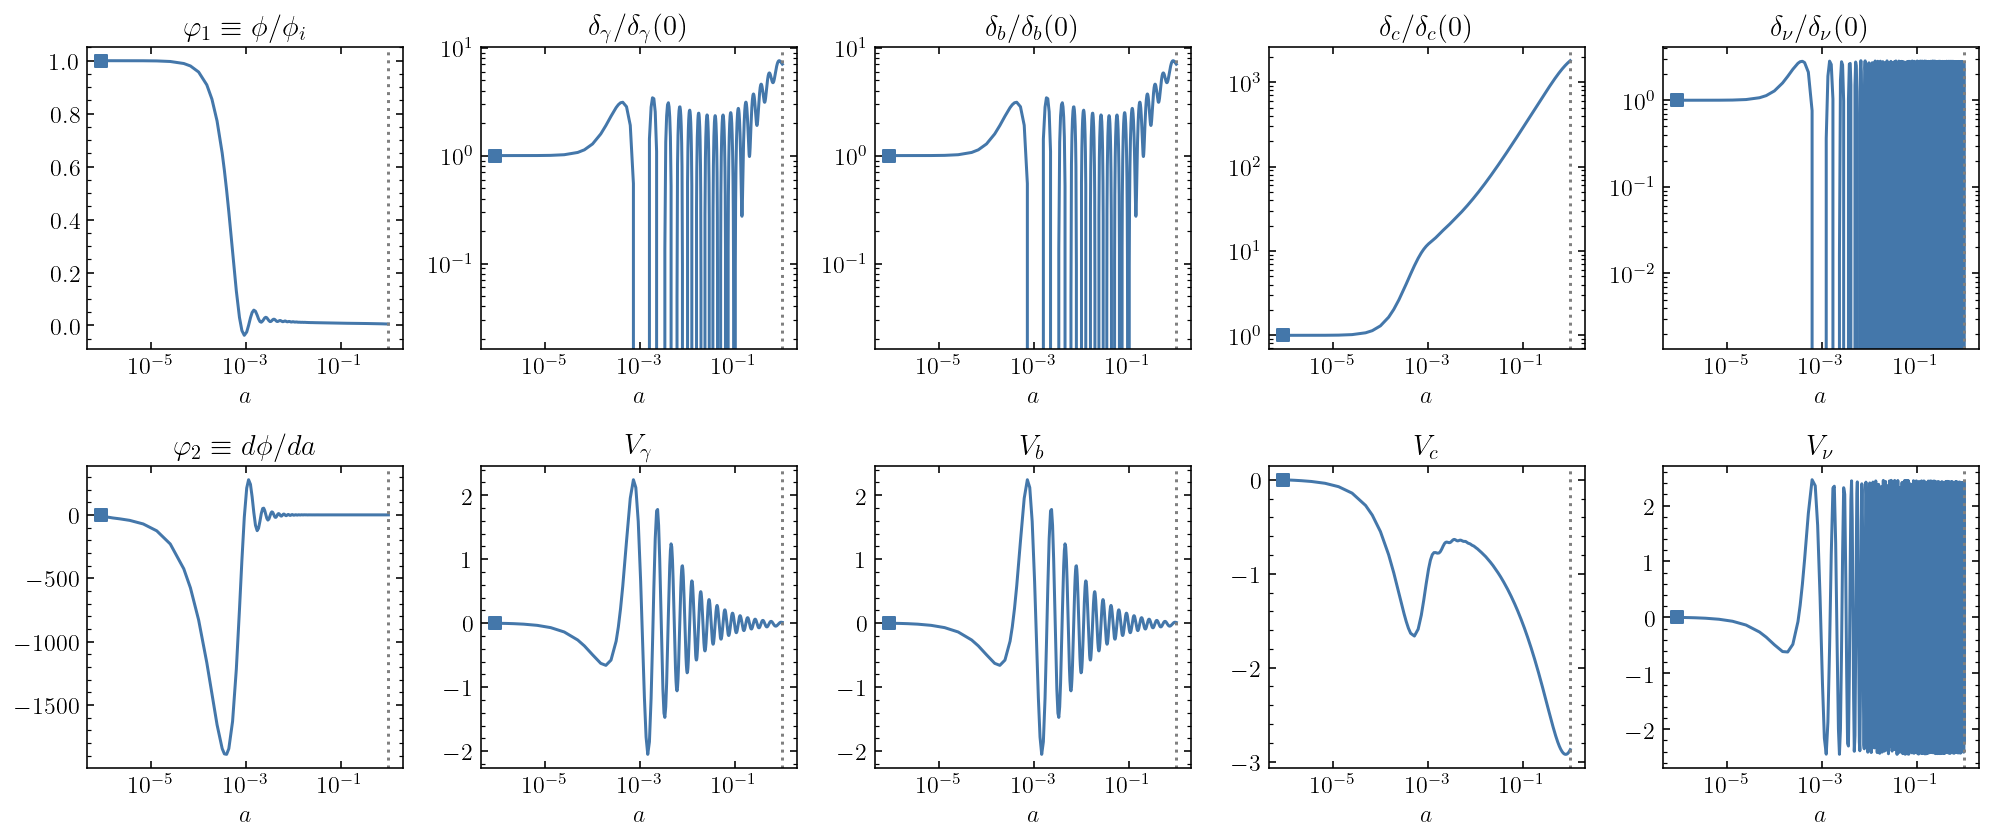

In [476]:
cpt.z_d = 0
result1 = cpt.solve(0.1 * (u.Mpc**-1))
results = [ result1 ]

fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(4, 5)

d_axes = [ fig.add_subplot(gs[0:2, i+1]) for i in range(4) ]
V_axes = [ fig.add_subplot(gs[2:4, i+1]) for i in range(4) ]
# phi_ax = fig.add_subplot(gs[1:3, 0])
phi_ax = fig.add_subplot(gs[0:2, 0])
phi_prime_ax = fig.add_subplot(gs[2:4, 0])

axs = np.concatenate( [d_axes + V_axes + [phi_ax, phi_prime_ax]] )

labels = [
    '$\\delta_\\gamma / \\delta_\\gamma(0)$',
    '$\\delta_b / \\delta_b(0)$',
    '$\\delta_c / \\delta_c(0)$',
    '$\\delta_\\nu / \\delta_\\nu(0)$',
    '$V_\\gamma$',
    '$V_b$',
    '$V_c$',
    '$V_\\nu$',
    '$\\varphi_1 \\equiv \\phi / \\phi_i$',
    '$\\varphi_2 \\equiv d\\phi/da$',
]

log_a_d = root_scalar(lambda log_a: cpt.redshift(log_a) - cpt.z_d, bracket=[-100, 0]).root

for i, (ax, label) in enumerate(zip(axs.flat, labels)):
    for j, result in enumerate(results):
        if i < 4:
            ax.plot(np.exp(result.t), result.y[i] / result.y[i][0], color=f'C{j}')
            ax.scatter(np.exp(result.t)[0], 1, c=f'C{j}', marker='s', s=32)
            ax.set_yscale('log')
        else:
            ax.plot(np.exp(result.t), result.y[i], color=f'C{j}')
            ax.scatter(np.exp(result.t)[0], result.y[i][0], c=f'C{j}', marker='s', s=32)
        # ax.plot([cpt.scale_factor(z) for z in result.t], result.y[i], color=f'C{j}')
        # ax.scatter(cpt.scale_factor(result.t[0]), result.y[i][0], c=f'C{j}', marker='s', s=32)
    # ax.set_xlim(z_0 * 2, z_1 / 2)
    ax.set_xscale('log')
    ax.set_title(label)
    ax.set_xlabel('$a$')
    ax.axvline(np.exp(log_a_d), ls=':', color='grey')
    # ax.set_xlim(*ax.get_xlim()[::-1])

# phi_ax.text(results[0].t[-1], results[0].y[8][-1] - 0.08, r'$10^{-1} \ \text{Mpc}^{-1}$', ha='right', va='bottom', fontsize=8, color='C0')
# phi_ax.text(results[1].t[-1], results[1].y[8][-1] - 0.08, r'$10^{-2} \ \text{Mpc}^{-1}$', ha='right', va='bottom', fontsize=8, color='C1')
# phi_ax.text(results[2].t[-1], results[2].y[8][-1] + 0.08, r'$10^{-3} \ \text{Mpc}^{-1}$', ha='right', va='bottom', fontsize=8, color='C2')
# phi_ax.set_ylim(-0.1, 1.1)

fig.tight_layout()
plt.show()

cpt.z_d = 1e3

Now we see the qualitatively correct behavior with photons and baryons: matching $V$ and $\delta$ with fast, decaying oscillations. It's just that these oscillations should have started closer to $a \sim 10^{-5}$ and finished around $10^{-3}$, rather than starting at $a \sim 10^{-3}$ and wrapping up around $a \sim 1$. And the neutrinos are still misbehaving.

Pretending that this code works, let's make a snapshot of $F \equiv \Theta_0 + \Phi = \delta_\gamma/4 + \varphi_1$ at $z_d$.

In [477]:
log_a_d = root_scalar(lambda log_a: cpt.redshift(log_a) - cpt.z_d, bracket=[-100, 0]).root
a_d = np.exp(log_a_d)

In [489]:
ks = np.geomspace(1e-3, 1, num=30) * (u.Mpc**-1)
Fs = np.zeros(len(ks))

for i, k in enumerate(tqdm(ks)):
    res = cpt.solve(k, a_final=a_d)
    d_g = res.y[0][-1]
    phi_1 = res.y[8][-1]
    Fs[i] = 0.25 * d_g + phi_1

  0%|          | 0/30 [00:00<?, ?it/s]

a_init = 8.8e-05
a_init = 6.9e-05
a_init = 5.4e-05
a_init = 4.3e-05
a_init = 3.4e-05
a_init = 2.7e-05
a_init = 2.1e-05
a_init = 1.6e-05
a_init = 1.3e-05
a_init = 1.0e-05
a_init = 8.1e-06
a_init = 6.4e-06
a_init = 5.0e-06
a_init = 3.9e-06
a_init = 3.1e-06
a_init = 2.4e-06
a_init = 1.9e-06
a_init = 1.5e-06
a_init = 1.2e-06
a_init = 9.4e-07
a_init = 7.4e-07
a_init = 5.9e-07
a_init = 4.6e-07
a_init = 3.6e-07
a_init = 2.9e-07
a_init = 2.3e-07
a_init = 1.8e-07
a_init = 1.4e-07
a_init = 1.1e-07
a_init = 8.7e-08


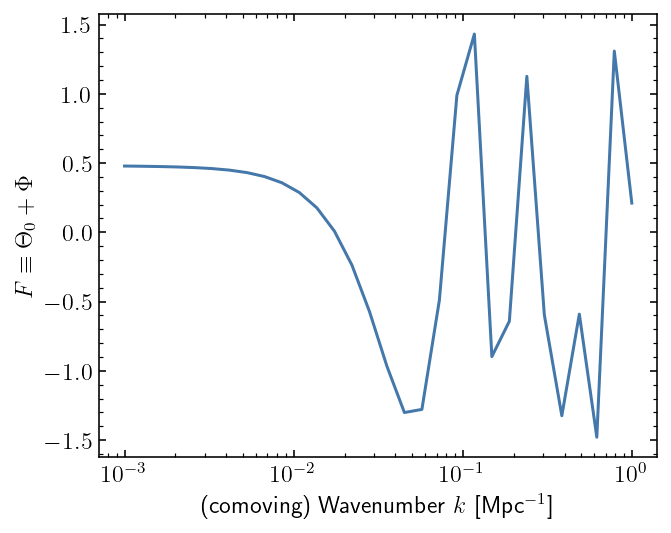

In [490]:
plt.plot(ks, Fs)
plt.xscale('log')
plt.ylabel('$F \\equiv \\Theta_0 + \\Phi$')
plt.xlabel('(comoving) Wavenumber $k$ [Mpc$^{-1}$]')
plt.show()

Looks oscillatory!